<a href="https://colab.research.google.com/github/tawiahnyt/phishing-detection/blob/main/Url_Detector_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack
import pandas as pd
import seaborn as sns
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('https://huggingface.co/datasets/imanoop7/phishing_url_classification/resolve/main/phishing_dataset.csv')

In [4]:
df.shape

(100000, 2)

In [5]:
df.head()

,text,label
0,http://serviceoffer.gov/login,1
1,http://debitmail.me/profile,1
2,https://www.washingtonpost.com,0
3,http://netflixinvest.edu/dashboard,1
4,https://www.reddit.com,0


In [6]:
df['label'].value_counts()

,count
label,
1,50000
0,50000


In [7]:
df.isnull().sum()

,0
text,0
label,0


In [8]:
df_malicious = df[df.label==1]
df_legitimate = df[df.label==0]


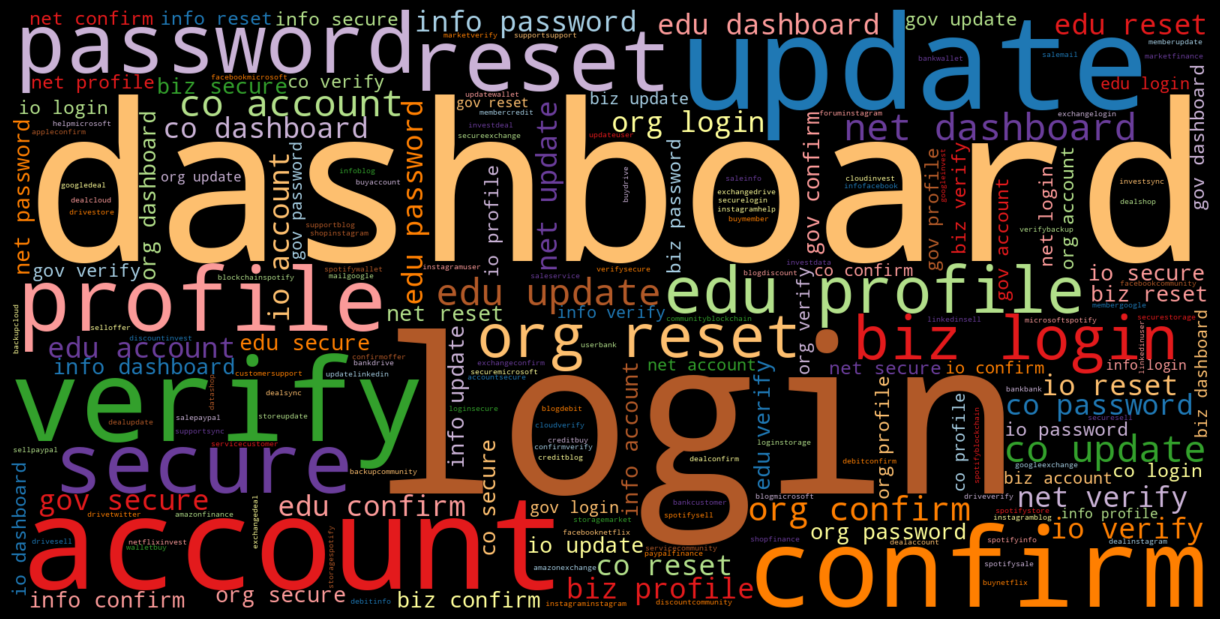

In [9]:
malicious_url = " ".join(i for i in df_malicious.text)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malicious_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

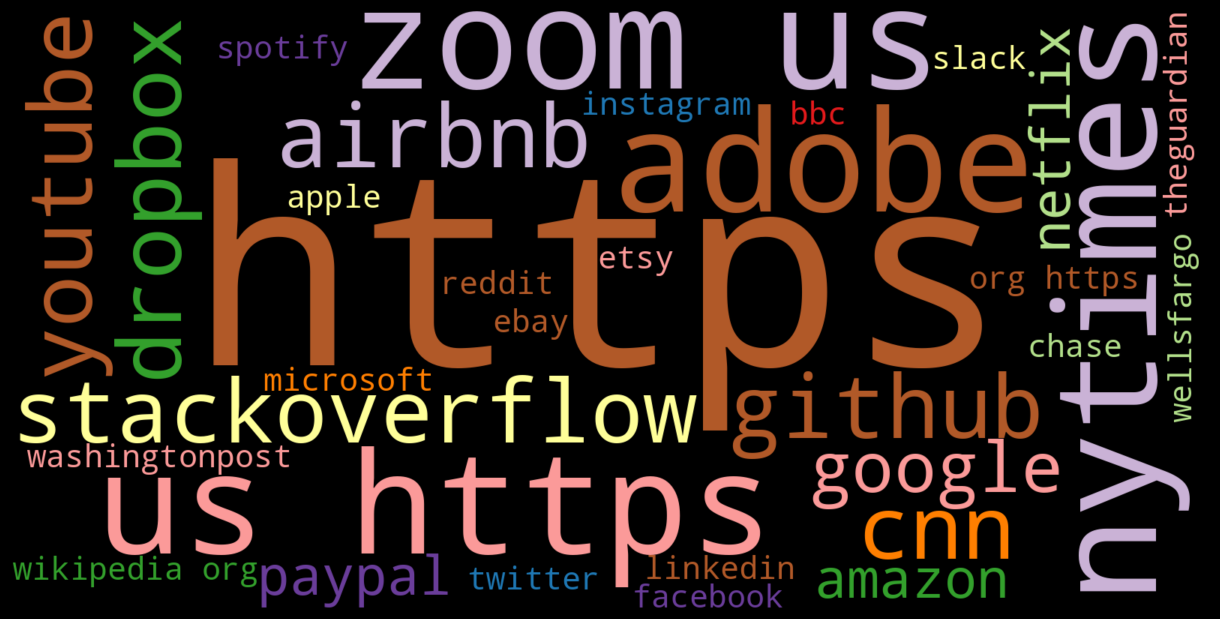

In [10]:
legitimate_url = " ".join(i for i in df_legitimate.text)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(legitimate_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [11]:
# Define your existing extractor
# def extract_features(url):
#     from urllib.parse import urlparse
#     import re

#     parsed = urlparse(url)
#     return {
#         'url_length': len(url),
#         'num_dots': url.count('.'),
#         'has_https': int(parsed.scheme == 'https'),
#         'domain_length': len(parsed.netloc),
#         'path_length': len(parsed.path),
#         'uses_ip': int(bool(re.match(r'\d+\.\d+\.\d+\.\d+', parsed.netloc))),
#         'num_special_chars': sum(1 for c in url if not c.isalnum() and c not in ['.', '/', ':']),
#         'has_at': int('@' in url),
#         'has_dash': int('-' in url),
#     }

In [12]:
def extract_features(url):
    from urllib.parse import urlparse
    import re

    parsed = urlparse(url)
    netloc = parsed.netloc
    path = parsed.path
    query = parsed.query

    features = {
        # Basic structural features
        'url_length': len(url),  # Total length of the URL
        'domain_length': len(netloc),  # Length of the domain
        'path_length': len(path),  # Length of the URL path
        'query_length': len(query),  # Length of the query string

        # Protocol
        'has_https': int(parsed.scheme == 'https'),  # 1 if HTTPS is used, 0 otherwise

        # Character and symbol analysis
        'num_dots': url.count('.'),  # Number of dot characters
        'num_hyphens': url.count('-'),  # Number of hyphens in the URL
        'num_underscores': url.count('_'),  # Number of underscores
        'num_slashes': url.count('/'),  # Number of forward slashes
        'num_percent': url.count('%'),  # Percent-encoding often used in obfuscated URLs
        'num_at': url.count('@'),  # Presence of '@' symbol (may hide actual domain)
        'num_colons': url.count(':'),  # Number of colon characters
        'num_digits': sum(c.isdigit() for c in url),  # Total number of digit characters
        'num_special_chars': sum(1 for c in url if not c.isalnum() and c not in ['.', '/', ':']),  # Non-alphanumeric special characters

        # Structural red flags
        'has_ip': int(bool(re.match(r'^\d{1,3}(\.\d{1,3}){3}$', netloc))),  # If domain is an IP address
        'has_at': int('@' in url),  # 1 if '@' is used
        'has_dash': int('-' in netloc),  # 1 if dash is in domain (can be suspicious)

        # Subdomain analysis
        'num_subdomains': netloc.count('.') - 1 if not re.match(r'^\d+\.\d+\.\d+\.\d+$', netloc) else 0,  # Number of subdomains (excluding IPs)

        # Presence of suspicious keywords (expandable list)
        'has_login': int('login' in url.lower()),
        'has_secure': int('secure' in url.lower()),
        'has_account': int('account' in url.lower()),
        'has_update': int('update' in url.lower()),
        'has_verify': int('verify' in url.lower()),
        'has_bank': int('bank' in url.lower()),

        # TLD and file extension
        'tld_length': len(netloc.split('.')[-1]) if '.' in netloc else 0,
        'has_exe': int('.exe' in url.lower()),  # Suspicious file extension
        'has_php': int('.php' in url.lower()),  # Common in dynamic (and sometimes malicious) URLs
    }

    return features


In [13]:
def extract_features(url):
    from urllib.parse import urlparse
    import re

    parsed = urlparse(url)
    netloc = parsed.netloc
    path = parsed.path
    query = parsed.query

    features = {
        # Basic structural features
        'url_length': len(url),  # Total length of the URL
        'domain_length': len(netloc),  # Length of the domain
        'path_length': len(path),  # Length of the URL path
        'query_length': len(query),  # Length of the query string

        # Protocol
        'has_https': int(parsed.scheme == 'https'),  # 1 if HTTPS is used, 0 otherwise

        # Character and symbol analysis
        'num_dots': url.count('.'),  # Number of dot characters
        'num_hyphens': url.count('-'),  # Number of hyphens in the URL
        'num_underscores': url.count('_'),  # Number of underscores
        'num_slashes': url.count('/'),  # Number of forward slashes
        'num_percent': url.count('%'),  # Percent-encoding often used in obfuscated URLs
        'num_at': url.count('@'),  # Presence of '@' symbol (may hide actual domain)
        'num_colons': url.count(':'),  # Number of colon characters
        'num_digits': sum(c.isdigit() for c in url),  # Total number of digit characters
        'num_special_chars': sum(1 for c in url if not c.isalnum() and c not in ['.', '/', ':']),  # Non-alphanumeric special characters

        # Structural red flags
        'has_ip': int(bool(re.match(r'^\d{1,3}(\.\d{1,3}){3}$', netloc))),  # If domain is an IP address
        'has_at': int('@' in url),  # 1 if '@' is used
        'has_dash': int('-' in netloc),  # 1 if dash is in domain (can be suspicious)

        # Subdomain analysis
        'num_subdomains': netloc.count('.') - 1 if not re.match(r'^\d+\.\d+\.\d+\.\d+$', netloc) else 0,  # Number of subdomains (excluding IPs)

        # Presence of suspicious keywords (expandable list)
        'has_login': int('login' in url.lower()),
        'has_secure': int('secure' in url.lower()),
        'has_account': int('account' in url.lower()),
        'has_update': int('update' in url.lower()),
        'has_verify': int('verify' in url.lower()),
        'has_bank': int('bank' in url.lower()),

        # TLD and file extension
        'tld_length': len(netloc.split('.')[-1]) if '.' in netloc else 0,
        'has_exe': int('.exe' in url.lower()),  # Suspicious file extension
        'has_php': int('.php' in url.lower()),  # Common in dynamic (and sometimes malicious) URLs
    }

    return features


In [14]:
# Feature sets
X_struct = pd.DataFrame([extract_features(url) for url in df['text']])
y = df['label']

In [15]:
X_struct.head()

,url_length,domain_length,path_length,query_length,has_https,num_dots,num_hyphens,num_underscores,num_slashes,num_percent,...,num_subdomains,has_login,has_secure,has_account,has_update,has_verify,has_bank,tld_length,has_exe,has_php
0,29,16,6,0,0,1,0,0,3,0,...,0,1,0,0,0,0,0,3,0,0
1,27,12,8,0,0,1,0,0,3,0,...,0,0,0,0,0,0,0,2,0,0
2,30,22,0,0,1,2,0,0,2,0,...,1,0,0,0,0,0,0,3,0,0
3,34,17,10,0,0,1,0,0,3,0,...,0,0,0,0,0,0,0,3,0,0
4,22,14,0,0,1,2,0,0,2,0,...,1,0,0,0,0,0,0,3,0,0


In [16]:
X_struct.columns

Index(['url_length', 'domain_length', 'path_length', 'query_length',
       'has_https', 'num_dots', 'num_hyphens', 'num_underscores',
       'num_slashes', 'num_percent', 'num_at', 'num_colons', 'num_digits',
       'num_special_chars', 'has_ip', 'has_at', 'has_dash', 'num_subdomains',
       'has_login', 'has_secure', 'has_account', 'has_update', 'has_verify',
       'has_bank', 'tld_length', 'has_exe', 'has_php'],
      dtype='object')

In [17]:
X_struct.shape

(100000, 27)

In [18]:
y.head()

,label
0,1
1,1
2,0
3,1
4,0


In [19]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5), max_features=500)
X_text = tfidf.fit_transform(df['text'])

In [20]:
# Combine both
from scipy.sparse import csr_matrix
X_combined = hstack([csr_matrix(X_struct.values), X_text])


In [21]:
X_combined

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5538682 stored elements and shape (100000, 527)>

In [22]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


In [23]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42, max_features='sqrt')
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred,target_names=['legitimate', 'malicious']))

score = accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

score = recall_score(y_test, y_pred)
print("recall:   %0.3f" % score)

score = f1_score(y_test, y_pred)
print("f1:   %0.3f" % score)

score = precision_score(y_test, y_pred)
print("precision:   %0.3f" % score)

              precision    recall  f1-score   support

  legitimate       1.00      1.00      1.00     10006
   malicious       1.00      1.00      1.00      9994

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

accuracy:   1.000
recall:   1.000
f1:   1.000
precision:   1.000


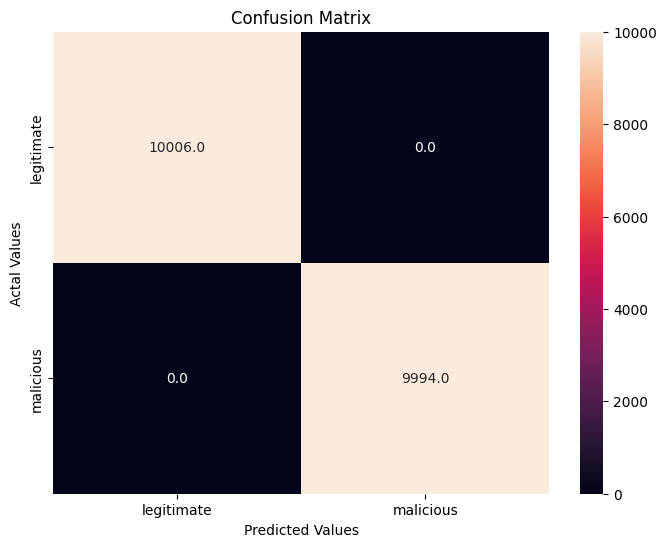

In [25]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['legitimate', 'malicious'],
                     columns = ['legitimate', 'malicious'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

Top Feature Importances:
            feature  importance
459           tp://    0.079134
68             //ww    0.069226
413             s:/    0.050000
2       path_length    0.042899
469           ttps:    0.041318
507            www.    0.040607
415           s://w    0.040173
363             p:/    0.037062
462           tps:/    0.034182
497             ww.    0.030342
17   num_subdomains    0.030329
468            ttps    0.030000
103           /www.    0.030000
394           ps://    0.030000
461            tps:    0.029905
5          num_dots    0.028375
172             com    0.021626
393            ps:/    0.021146
102            /www    0.021106
458            tp:/    0.020000


<ipython-input-26-abe864ff39bc>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')


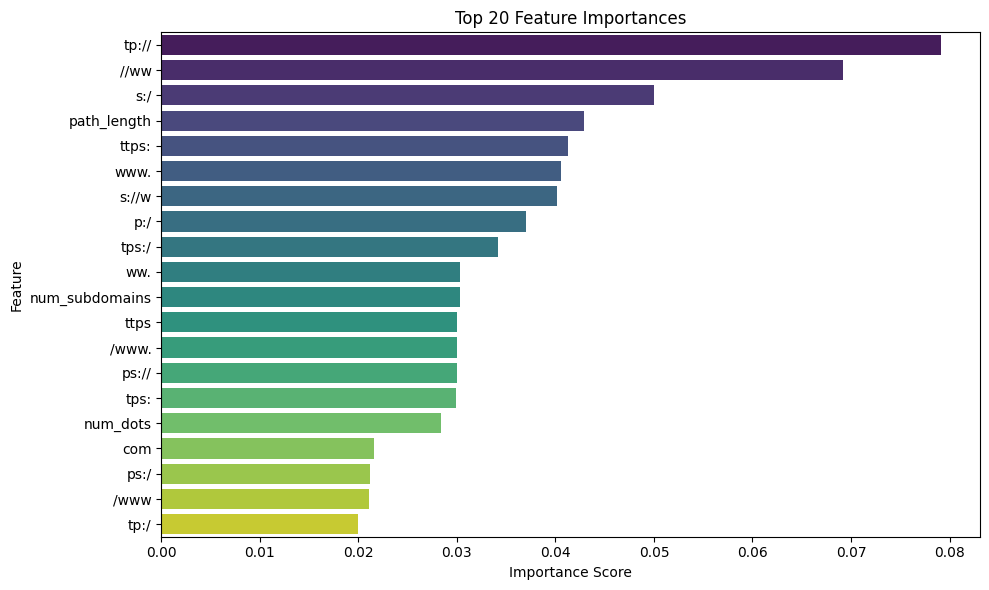

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained RandomForest model
importances = model.feature_importances_

# Combine feature names
structural_feature_names = X_struct.columns.tolist()
tfidf_feature_names = tfidf.get_feature_names_out().tolist()
all_feature_names = structural_feature_names + tfidf_feature_names

# Create DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Display top 20 features
top_n = 20
top_features = feature_importance_df.head(top_n)

# Print to console
print("Top Feature Importances:")
print(top_features)

# Plot top 20 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title(f'Top {top_n} Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [32]:
!pip install lime==0.2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7a0b0bdf10cd9a2e819b4533ae9ea240089e9466929cfd16172523d131f04498
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


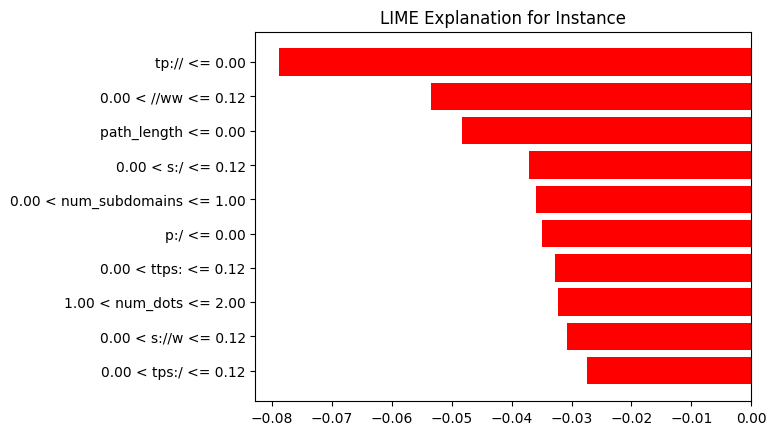

LIME Explanation for Instance:
tp:// <= 0.00: -0.0787
0.00 < //ww <= 0.12: -0.0534
path_length <= 0.00: -0.0483
0.00 < s:/ <= 0.12: -0.0371
0.00 < num_subdomains <= 1.00: -0.0359
p:/ <= 0.00: -0.0349
0.00 < ttps: <= 0.12: -0.0328
1.00 < num_dots <= 2.00: -0.0322
0.00 < s://w <= 0.12: -0.0308
0.00 < tps:/ <= 0.12: -0.0274


In [33]:
from lime import lime_text
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# LIME is designed for interpreting individual predictions.
# For tabular data (like your combined features), you can use LimeTabularExplainer
# You'll need the training data, feature names, and class names

# Convert sparse matrix X_train to a dense numpy array for LIME
# Note: This might require significant memory for large datasets
X_train_dense = X_train.toarray()

# Get class names
class_names = ['legitimate', 'malicious']

# Create a LIME explainer
explainer_lime = LimeTabularExplainer(
    training_data=X_train_dense,
    feature_names=all_feature_names,
    class_names=class_names,
    mode='classification'
)

# Choose an instance from the test set to explain (as a dense array)
instance_to_explain_dense = X_test[0].toarray()[0] # Get the first row and convert to dense array

# Explain the instance
explanation = explainer_lime.explain_instance(
    data_row=instance_to_explain_dense,
    predict_fn=model.predict_proba,
    num_features=10 # Number of features to show in the explanation
)

# Visualize the explanation
explanation.as_pyplot_figure()
plt.title("LIME Explanation for Instance")
plt.show()

# Print the explanation details
print("LIME Explanation for Instance:")
for feature, weight in explanation.as_list():
    print(f"{feature}: {weight:.4f}")

In [34]:
external_urls = [
    # 'https://malicious-domain.com/payload.exe',
    # 'https://shorturl.at/puTSm',
    # 'https://shorturl.at/IqMom',
    # "https://paypal.com/login",
    # "http://secure-update.bankofamerica.support",
    # "https://github.com",
    # "http://google.verify-center.login.info",
    # "https://university.edu",
    # "http://paypal-useraccount.cf/login",
    # "https://chat.openai.com",
    # "https://site.gctu.edu.gh",
    # 'titaniumcorporate.co.za',
    # 'https://en.wikipedia.org/wiki/North_Dakota',
    # 'https://colab.research.google.com',
    # 'https://www.youtube.com/',
    # 'https://dafriedman97.github.io/mlbook/content/introduction.html',
    # 'https://github.com',
    # 'https://site.gctu.edu.gh/',
    # 'https://meet.google.com/bkd-bgiu-vdt',
    'https://www.plug.tech/collections/sale'
]

# Extract features
external_struct = pd.DataFrame([extract_features(url) for url in external_urls])
external_text = tfidf.transform(external_urls)
external_combined = hstack([csr_matrix(external_struct.values), external_text])

# Predict
external_probs = model.predict_proba(external_combined)[:, 1]
external_preds = (external_probs > 0.5).astype(int)

# Show results
results = pd.DataFrame({
    'url': external_urls,
    'malicious_probability': external_probs,
    'predicted_label': external_preds
})

print(results)


                                      url  malicious_probability  \
0  https://www.plug.tech/collections/sale                   0.06   

   predicted_label  
0                0  


In [40]:
# # Log uncertain predictions for review
# uncertain = (external_probs > 0.5) & (external_probs < 0.95)
# uncertain_urls = [url for i, url in enumerate(external_urls) if uncertain[i]]

# print("🧐 URLs to review manually:")
# for url in uncertain_urls:
#     print(url)


In [35]:
import pickle
filename = 'malicious.sav'
pickle.dump(model, open(filename, 'wb'))
# Loading the saved model
loaded_model = pickle.load(open('malicious.sav', 'rb'))

In [39]:
input_data = 'https://animeheaven.me/episode.php?8a92ee99ebb05c3a3f7254d210fbe1fe'

# Wrap the dictionary in a list to create a single-row DataFrame
external_struct = pd.DataFrame([extract_features(input_data)])
external_text = tfidf.transform([input_data]) # Also transform the single input URL
external_combined = hstack([csr_matrix(external_struct.values), external_text])

# Predict
external_probs = loaded_model.predict_proba(external_combined)[:, 1]
external_preds = (external_probs > 0.5).astype(int)

# Show results
results = pd.DataFrame({
    'url': [input_data], # Ensure url is also a list
    'malicious_probability': external_probs,
    'predicted_label': external_preds
})

print(results.to_json())

{"url":{"0":"https:\/\/animeheaven.me\/episode.php?8a92ee99ebb05c3a3f7254d210fbe1fe"},"malicious_probability":{"0":0.43},"predicted_label":{"0":0}}
